## 作业内容
**使用决策树模型预测titanic乘客生存率**


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

In [2]:
train=pd.read_csv("./titanic/train.csv")

test=pd.read_csv("./titanic/test.csv")
# 合并数据集
full = train.append( test , ignore_index = True )


full.head()

D:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [3]:
#数据预处理
#查看是否有缺失值
full.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
#年龄(Age)
full['Age']=full['Age'].fillna( full['Age'].mean() )
#船票价格(Fare)
full['Fare'] = full['Fare'].fillna( full['Fare'].mean() )
#缺失数据比较多，船舱号（Cabin）缺失值填充为U，表示未知（Uknow） 
full['Cabin'] = full['Cabin'].fillna( 'U' )
#登船港口
full['Embarked'] = full['Embarked'].fillna( 'S')
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
full['Sex']=full['Sex'].map({'male':1,'female':0})
embarkedDf=pd.get_dummies(full['Embarked'],prefix='Embarked')
full = pd.concat([full,embarkedDf],axis=1)
# 删除Embarked列
full.drop('Embarked',axis=1,inplace=True)

# 删除Name列
full.drop('Name',axis=1,inplace=True)
# 删除船票
full.drop('Ticket',axis=1,inplace=True)

# 定义家庭成员
familyDf=pd.DataFrame()

#家庭人数=同代直系亲属数（Parch）+不同代直系亲属数（SibSp）+乘客自己
familyDf['FamilySize']=full[ 'Parch' ] + full[ 'SibSp' ] + 1
familyDf['Family_Single' ] = familyDf['FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
familyDf['Family_Small']=familyDf['FamilySize'].map(lambda s:1 if 2 <= s <= 4  else 0)
familyDf['Family_Large']=familyDf['FamilySize'].map(lambda s:1 if 4 <s  else 0)

full = pd.concat([full,familyDf],axis=1)
full.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,U,7.2500,0,1,3,1,1,0.0,0,0,1,2,0,1,0
1,38.0,C85,71.2833,0,2,1,0,1,1.0,1,0,0,2,0,1,0
2,26.0,U,7.9250,0,3,3,0,0,1.0,0,0,1,1,1,0,0
3,35.0,C123,53.1000,0,4,1,0,1,1.0,0,0,1,2,0,1,0
4,35.0,U,8.0500,0,5,3,1,0,0.0,0,0,1,1,1,0,0


In [6]:
# 获得特征处理后的训练集和测试集
train_data=full.loc[:891-1,:]
test_data=full.loc[891:,:]
# print(len(train_data))
# print(test_data.shape)
train_data.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,U,7.2500,0,1,3,1,1,0.0,0,0,1,2,0,1,0
1,38.0,C85,71.2833,0,2,1,0,1,1.0,1,0,0,2,0,1,0
2,26.0,U,7.9250,0,3,3,0,0,1.0,0,0,1,1,1,0,0
3,35.0,C123,53.1000,0,4,1,0,1,1.0,0,0,1,2,0,1,0
4,35.0,U,8.0500,0,5,3,1,0,0.0,0,0,1,1,1,0,0


In [7]:
# 获得特征之间的相关性
corrDf = train_data.corr()
corrDf['Survived'].sort_values(ascending =False)


Survived         1.000000
Family_Small     0.279855
Fare             0.257307
Embarked_C       0.168240
Parch            0.081629
FamilySize       0.016639
Embarked_Q       0.003650
PassengerId     -0.005007
SibSp           -0.035322
Age             -0.070323
Family_Large    -0.125147
Embarked_S      -0.149683
Family_Single   -0.203367
Pclass          -0.338481
Sex             -0.543351
Name: Survived, dtype: float64

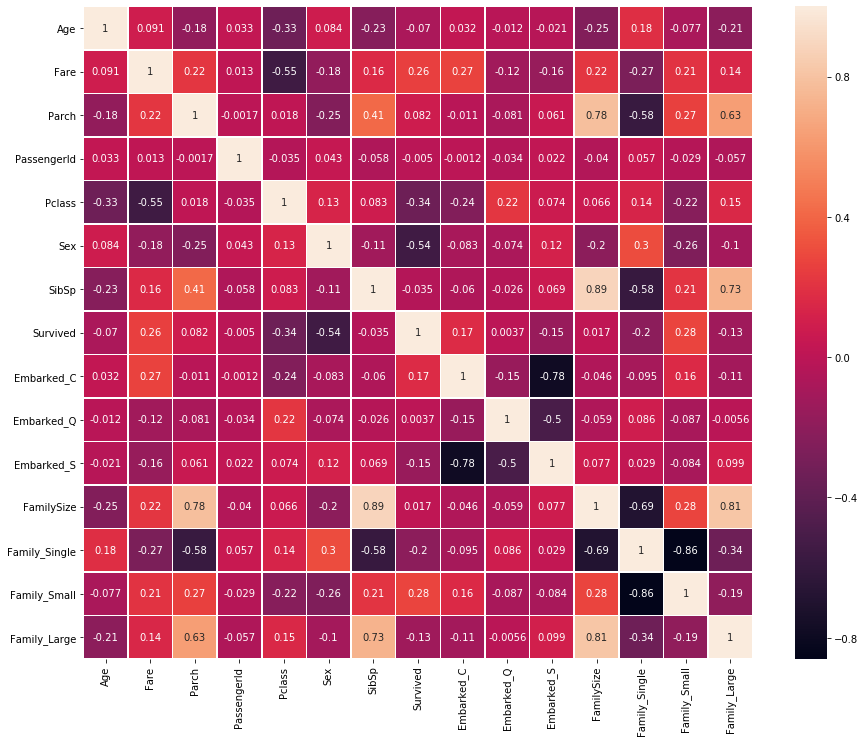

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(15, 12),sharex=True)
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, ax=axes)

In [9]:
# 根据相关系数倒数排序，发现Survived和familyDf（Family_Small，FamilySize），Fare,Parch,embarkedDf 有比较大的关系，考虑到逃生优先妇女和儿童的策略
# 加上sex和age特征
# 获得最终的测试集和训练集
train_feature = pd.concat( [
                     train_data['FamilySize'],
                     train_data['Family_Single'],
                     train_data['Family_Large'],
                     train_data['FamilySize'],
                     train_data['Fare'],#船票价格
                     train_data['Parch'],
                     train_data['Embarked_C'],#登船港口
                     train_data['Embarked_S'],#登船港口
                     train_data['Embarked_Q'],#登船港口  
                     train_data['Sex'],#性别
                     train_data['Age'],#年龄
                    ] , axis=1 )


test_feature = test_data[train_feature.columns]

test_feature.head()

,FamilySize,Family_Single,Family_Large,FamilySize,Fare,Parch,Embarked_C,Embarked_S,Embarked_Q,Sex,Age
891,1,1,0,1,7.8292,0,0,0,1,1,34.5
892,2,0,0,2,7.0000,0,0,1,0,0,47.0
893,1,1,0,1,9.6875,0,0,0,1,1,62.0
894,1,1,0,1,8.6625,0,0,1,0,1,27.0
895,3,0,0,3,12.2875,1,0,1,0,0,22.0


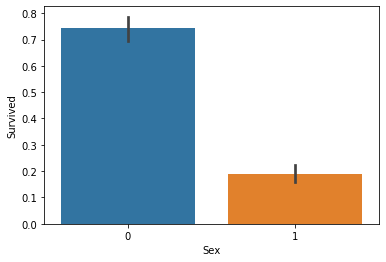

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


# 年龄与Survived 关系
sns.barplot(x="Sex", y="Survived", data=pd.DataFrame(train_data))



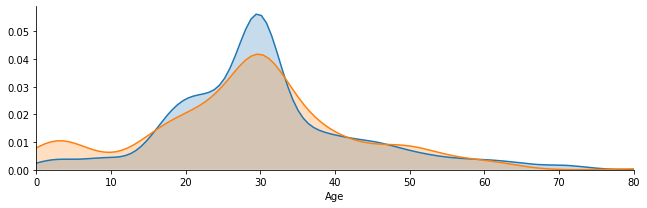

In [28]:
# 画出年的密度函数
ageFacet=sns.FacetGrid(train_data,hue='Survived',aspect=3)
# #作图，选择图形类型
ageFacet.map(sns.kdeplot,'Age',shade=True)
# #其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,train_data['Age'].max()))
# ageFacet.add_legend()
# 有图可知年龄在0-10岁的生存率较高

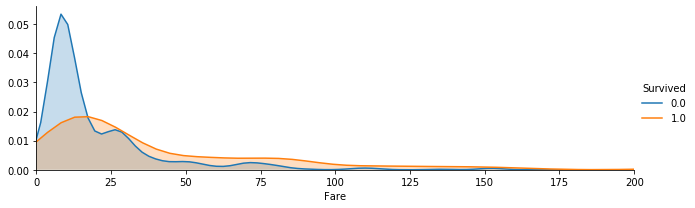

In [12]:
#  画出票价密度函数
ageFacet=sns.FacetGrid(train_data,hue='Survived',aspect=3)
#作图，选择图形类型
ageFacet.map(sns.kdeplot,'Fare',shade=True)
#其他信息：坐标轴范围、标签等
ageFacet.set(xlim=(0,200))
ageFacet.add_legend()
# 当票价低于18左右时乘客生存率较低，票价越高生存率一般越高

In [13]:
# 模型初始化
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 获得训练接和标签集
outcomes = train_data['Survived']
features = train_feature
# 划分数据（2/8分）
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2, random_state=42)

# 决策时模型分类
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

#预测标签
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 使用准确率衡量模型
train_accuracy=accuracy_score(y_train,y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("train_accuracy:",train_accuracy)
print("test_accuracy:",test_accuracy)

train_accuracy: 0.9803370786516854
test_accuracy: 0.7541899441340782


In [14]:
from sklearn.model_selection import GridSearchCV

clf=DecisionTreeClassifier()

param_grid = [
    {
        'criterion': np.array(['entropy','gini']),
        'max_depth':range(1,20,2),
        'min_samples_leaf':np.array([1,3,5,6])
    }
]

# cv：交叉验证参数
grid_search = GridSearchCV(clf,param_grid,n_jobs=1, cv=5,verbose=2)
grid_search.fit(X_train,y_train)

print("得到的最好的KNN分类器信息:\n",grid_search.best_estimator_)

print('最好的分类器预测的结果:\n',grid_search.best_score_)

print('网格搜索的最优参数:\n',grid_search.best_params_)
clf = grid_search.best_estimator_
acc = clf.score(X_test,y_test)
print('预测准确率为：\n',acc)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=1 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=1, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=1, min_samples_leaf=3 ..............
[CV]  cri

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV]  criterion=entropy, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 ..............
[CV]  criterion=entropy, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=entropy, max_depth=3, min_samples_leaf=5 .............

[CV] criterion=entropy, max_depth=11, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=3, total=   0.0s
[CV] criterion=entropy, max_depth=11, min_samples_leaf=3 .............
[CV]  criterion=entropy, max_depth=11, min_samples_leaf=3, total=

[CV]  criterion=entropy, max_depth=15, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=15, min_samples_leaf=6 .............
[CV]  criterion=entropy, max_depth=15, min_samples_leaf=6, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=1 .............
[CV]  criterion=entropy, max_depth=17, min_samples_leaf=1, total=   0.0s
[CV] criterion=entropy, max_depth=17, min_samples_leaf=1 ......

[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=5 .................
[CV] .

[CV] .. criterion=gini, max_depth=9, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=9, min_samples_leaf=6 .................
[CV] .. criterion=gini, max_depth=9, min_samples_leaf=6, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=1 ................
[CV] . criterion=gini, max_depth=11, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=11, min_samples_leaf=1 ................
[CV] .

[CV] . criterion=gini, max_depth=17, min_samples_leaf=1, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=3 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV] . criterion=gini, max_depth=17, min_samples_leaf=5, total=   0.0s
[CV] criterion=gini, max_depth=17, min_samples_leaf=5 ................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    3.0s finished


In [34]:
# 生成结果集
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] =clf.predict(test_feature)
sub.to_csv('submit.csv', index=False)